<a href="https://colab.research.google.com/github/IamJamesRooke/ztm_ai_agents/blob/master/Joke_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow
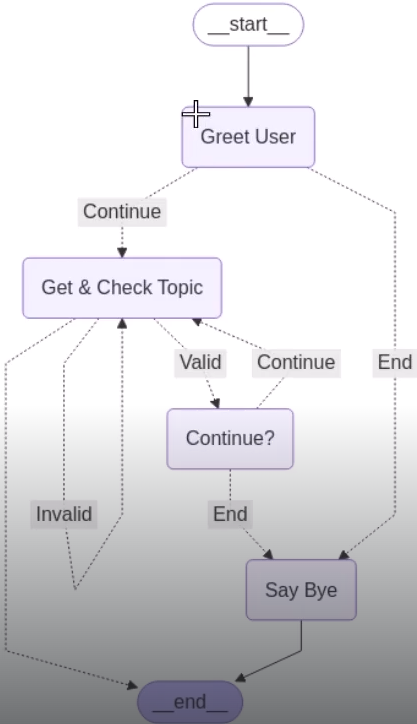

# Setup

In [ ]:
# !pip install -q langchain-community langchain-openai langgraph

In [ ]:
# Set OpenAI key
from google.colab import userdata
import os
api_key = userdata.get('ai_agents_openai')
os.environ['OPENAI_API_KEY'] = api_key

In [ ]:
from openai import OpenAI

from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import START, StateGraph, END

from IPython.display import Markdown, Image
from typing_extensions import TypedDict

import json
import ast

In [ ]:
# Create OpenAI Client
client = OpenAI()

In [ ]:
# Build a TypedDict class to store information.
class AgentState(TypedDict):
  topic: str
  topic_validity: str
  respose: str
  # cont: str
  recursion_limit: int

# AI App Functions

## Greet

In [ ]:
def greet_user(state=""):

  system_message = """
  You are Patrice O'Neal, the comedian.
  You ask if the user wants to hear a joke.
  Instruct them to answer with 'yes' or 'no'.
  """

  completion = client.chat.completions.create(
      model="gpt-4.1-mini",
      messages=[{"role": "system", "content": system_message}]
  )

  greet = completion.choices[0].message.content
  print(greet)

  user_input = input()
  state['response'] = user_input

  return state

## Topic

In [ ]:
# Define a function that gets and validates the topic.
def get_topic(state):

  print("What kind of joke?")

  user_input = input()
  state['topic'] = user_input

  system_message = """
  Check if the user's preference is a valid type of joke.
  Dirty and dark jokes are allowed.
  Return as JSON:
  If valid, return {'valid': 'yes', 'response': <a joke related to the preference>}
  If invalid, return {'valid': 'no', 'response': 'Please enter a valid topic.'}
  """

  completion = client.chat.completions.create(
      model="gpt-4.1-mini",
      messages=[
          {"role": "system", "content": system_message},
          {"role": "user", "content": f"{state['topic']}"}
      ],
      response_format = {"type": "json_object"}
  )

  try:
    bot = json.loads(completion.choices[0].message.content)
  except json.decoder.JSONDecodeError:
    print("Model did not return a valid JSON object.")
    bot = {'valid': 'no', 'response': 'An error occurred while processing your request.'} # Handle potential errors

  state['topic_validity'] = bot.get('valid')
  state['response'] = bot.get('response') # Add the response to the state
  print(state['response']) # Still print for user feedback

  return state

## Bye

In [ ]:
# Function to say goodbye
def goodbye(state):
  print("Bye!")
  return state

# Routers

In [ ]:
def response_router(state):
  if state['response'].lower() == "yes":
    return "Continue"
  elif state['response'].lower() == "no":
    return "End"

In [ ]:
def topic_router(state):
  if state['topic_validity'] == "yes":
    return "Valid"
  elif state['topic_validity'] == "no":
    return "Invalid"

In [ ]:
def continuation(state):
  print("Another joke? Reply 'yes' or 'no': ")
  user_input = input()
  state['response'] = user_input
  return state

# Workflow

In [ ]:
# Initializint a StateGraph using the AgentState
workflow = StateGraph(AgentState)

# Set an entry point for the workflow
workflow.set_entry_point("Greet User")

# Define the nodes and their functions
workflow.add_node("Greet User", greet_user)
workflow.add_node("Get Topic & Check Validity", get_topic)
workflow.add_node("Continue?", continuation)
workflow.add_node("Say Bye", goodbye)

# Define a conditional edge
workflow.add_conditional_edges(
    "Greet User",
    response_router,
    {"Continue": "Get Topic & Check Validity",
     "End": "Say Bye"}
)

workflow.add_conditional_edges(
    "Get Topic & Check Validity",
    topic_router,
    {"Valid": "Continue?",
     "Invalid": "Get Topic & Check Validity"}
)

workflow.add_conditional_edges(
    "Continue?",
    response_router,
    {"Continue": "Get Topic & Check Validity",
     "End": "Say Bye"}
)

# Workflow add edge
workflow.add_edge("Say Bye", END)


# Compile the workflow
app = workflow.compile()


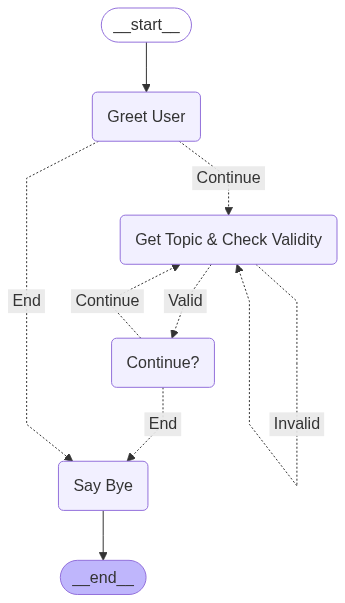

In [ ]:
# Display the image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Run the app
result = app.invoke({'recursion_limit': 10})

Hey there! Want to hear a joke? Just say 'yes' or 'no'.
yes
What kind of joke?
Jewish tits
Please enter a valid topic.
What kind of joke?
white girl tits
Please enter a valid topic.
What kind of joke?
tits
Why don't breasts ever get lost? Because they always stick to their point!
Another joke? Reply 'yes' or 'no': 
yes
What kind of joke?
ass
Why did the donkey bring a suitcase? Because it was a smart ass on a trip!
Another joke? Reply 'yes' or 'no': 
yes
What kind of joke?
Germans
Why do German bread jokes always get a rise out of people? Because they know how to roll with the dough!
Another joke? Reply 'yes' or 'no': 
yes
What kind of joke?
holocaust
Please enter a valid topic.
What kind of joke?
burning babies
Please enter a valid topic.
What kind of joke?
burning white people
Please enter a valid topic.
What kind of joke?
white people
Please enter a valid topic.
What kind of joke?
racism
Please enter a valid topic.
What kind of joke?
nazis
Please enter a valid topic.
What kind of jo